In [10]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [11]:
save = False

In [12]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [13]:
categories_control = ['original',
                      'length-control',
                      'constant-control']
                      

categories_scrambled = ['original',
                        'length-control',
                        'constant-control',
                        'scrambled1',
                        'scrambled3',
                        'scrambled5',
                        'scrambled7',
                        'backward',
                        'lowpmi',
                        'lowpmi-random',
                        'random-wl']

categories_perturb_loss = ['original',
                           'length-control',
                           'constant-control',
                           'nouns',
                           'nounsverbs',
                           'nounsverbsadj',
                           'contentwords',
                           'random-nouns',
                           'functionwords']

categories_perturb_meaning = ['sentenceshuffle_passage',
                              'sentenceshuffle_topic',
                              'sentenceshuffle_random']

categories_perturb = categories_perturb_loss + categories_perturb_meaning

categories = [categories_perturb, categories_scrambled, categories_control]
keys = ["perturb", "scrambled", "control"]

categories_dict = dict(zip(keys, categories))

In [14]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [15]:
from brainio_base.assemblies import DataAssembly, merge_data_arrays
from brainscore.metrics import Score

from scipy.stats import median_abs_deviation

def aggregate_neuroid_scores(neuroid_scores, subject_column):
    subject_scores = neuroid_scores.groupby(subject_column).median()
    center = subject_scores.median(subject_column)
    subject_values = np.nan_to_num(subject_scores.values, nan=0)  # mad cannot deal with all-nan in one axis, treat as 0
    subject_axis = subject_scores.dims.index(subject_scores[subject_column].dims[0])
    error = median_abs_deviation(subject_values, axis=subject_axis)
    score = Score([center, error], coords={'aggregation': ['center', 'error']}, dims=['aggregation'])
    score.attrs['raw'] = neuroid_scores
    score.attrs['description'] = "score aggregated by taking median of neuroids per subject, " \
                                 "then median of subject scores"
    return score

In [16]:
#aggregation from pipeline
from brainscore.metrics.transformations import  apply_aggregate

def get_visual_score(content_of_picklefile):
    visual_score_matrix = []
    all_raw_scores = content_of_picklefile["data"].raw.raw.raw
    
    # same as https://github.com/carina-kauf/perturbed-neural-nlp/blob/master/neural_nlp/benchmarks/neural.py#L173
    raw_neuroids = apply_aggregate(lambda values: values.mean('split').mean('experiment'), all_raw_scores)
    visual_neuroids = raw_neuroids.sel(atlas='visual', _apply_raw=False)
    layers = list(visual_neuroids.layer.data)
    
    for layer in layers:
        visual_neuroids.sel(layer=layer)
        score = aggregate_neuroid_scores(visual_neuroids.sel(layer=layer), "subject")
#         print(f"{layer} | Score: {score.data}")
        visual_score_matrix.append(score.data)
    return visual_score_matrix

In [17]:
def get_best_scores_df(model_identifier, categories_dict,
                       emb_context="Passage", split_coord="Sentence",
                       scr_perturb=None, testonperturbed=False):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue            
                
        include_condition = False
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                include_condition = True
            elif ("length-control" in filename) or ("constant-control" in filename):
                include_condition = True
            
            if include_condition == True:
#                 print(filename)
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                
                elif scr_perturb == "control":
                    condition = re.sub("scrambled-","",condition)
#                 print(condition)

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                visual_score_matrix = get_visual_score(out)
#                 print(md_score_matrix, '\n\n')
                max_score, error = get_max_score(visual_score_matrix)
                
                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    return scores_df

In [18]:
#function check
scores_df = get_best_scores_df("distilgpt2",categories_dict,scr_perturb="control")
scores_df

/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


,score,error,condition
2,0.242959,0.017801,original
1,0.003194,0.016313,length-control
0,0.024639,0.029763,constant-control


In [19]:
def bar_plot(model_identifier, scores_df, scr_perturb=None):
    colors = sns.color_palette("BuGn")
    x_pos = np.arange(len(scores_df))
    scores = scores_df['score']
    errors = scores_df['error']
    conditions = scores_df['condition']
    
#     print(np.unique(list(conditions)))
    
    # abbreviate condition names for perturb
    new_conditions = []
    for elm in conditions:
        if "sentenceshuffle_random" in elm:
            elm = re.sub("sentenceshuffle_random","sent_random",elm)
        if elm == "sentenceshuffle_passage":
            elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
        if elm == "sentenceshuffle_topic":
            elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
        new_conditions.append(elm)
    conditions = new_conditions
    
    fig, ax = plt.subplots()
    ax.bar(x_pos, scores,
       yerr=errors,
       align='center',
#        alpha=0.8, #color intensity
       ecolor='black',
       capsize=5, #error bar width
       color=colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
    ax.set_ylabel('unceiled score',fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(conditions, rotation=90)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    ax.set_title('UNNORMALIZED visual SCORES | {}'.format(model_identifier),fontsize=18)
    ax.yaxis.grid(True)
    if not model_identifier == "gpt2-xl":
        ax.set_ylim([0,1])
    else:
        ax.set_ylim([0,1.5])

    plt.show()

In [20]:
def main_plot(model_identifier,categories_dict,scr_perturb="scrambled"):
    scores_df = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb)
    bar_plot(model_identifier,scores_df,scr_perturb=scr_perturb)

In [21]:
# main_plot('distilgpt2',categories_dict,scr_perturb="control")
# main_plot('distilgpt2',categories_dict,scr_perturb="scrambled")
# main_plot('distilgpt2',categories_dict,scr_perturb="perturb")

In [22]:
teston_categories_control = ['teston:original',
                      'teston:length-control',
                      'teston:constant-control']
                      

teston_categories_scrambled = ['teston:original',
                        'teston:length-control',
                        'teston:constant-control',
                        'teston:scr1',
                        'teston:scr3',
                        'teston:scr5',
                        'teston:scr7',
                        'teston:backward',
                        'teston:lowpmi',
                        'teston:lowpmi-random',
                        'teston:random-wl']

teston_categories_perturb_loss = ['teston:original',
                           'teston:length-control',
                           'teston:constant-control',
                           'teston:nouns',
                           'teston:nounsverbs',
                           'teston:nounsverbsadj',
                           'teston:contentwords',
                           'teston:random-nouns',
                           'teston:functionwords']

teston_categories_perturb_meaning = ['teston:sentenceshuffle_passage',
                              'teston:sentenceshuffle_topic',
                              'teston:sentenceshuffle_random']

teston_categories_perturb = teston_categories_perturb_loss + teston_categories_perturb_meaning

categories = [teston_categories_perturb, teston_categories_scrambled, teston_categories_control]
keys = ["perturb", "scrambled", "control"]

categories_dict_teston = dict(zip(keys, categories))

In [23]:
def get_best_scores_df_testonperturbed(model_identifier, categories_dict_teston,
                       emb_context="Passage", split_coord="Sentence",
                       scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the maximum score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not any(x in filename for x in categories_dict_teston[scr_perturb]):
            continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue     
                
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
#             print(filename)
            condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
#             print(condition)

            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            visual_score_matrix = get_visual_score(out)
#                 print(md_score_matrix, '\n\n')
            max_score, error = get_max_score(visual_score_matrix)

            conditions.append(condition)
            max_scores.append(max_score)
            errors.append(error)
                
    import pandas as pd
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict_teston[scr_perturb])
    scores_df = df.sort_values(by='condition').reset_index(drop=True)
    return scores_df

In [24]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(model_list, scr_perturb=None):
    nsubplots = len(model_list) * 4 #original, decontextualized, passagesplit, teston:perturbed
    nrows = math.ceil(nsubplots/2)
    colors = sns.color_palette("BuGn")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 6*nrows))
    fig2.suptitle('{}'.format(scr_perturb), fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                if i%4 == 0:
                    scores_df = get_best_scores_df(model_list[counter % len(model_list)],categories_dict,scr_perturb=scr_perturb)
                    title_addition = ""
                elif i%3 == 0:
                    scores_df = get_best_scores_df_testonperturbed(model_list[counter % len(model_list)], categories_dict_teston,scr_perturb=scr_perturb)
                    title_addition = " | teston:perturbed"
                elif i%2 == 0:
                    scores_df =  get_best_scores_df(model_list[counter % len(model_list)], categories_dict,scr_perturb=scr_perturb, split_coord="Passage")
                    title_addition = " | split_coord = Passage"
                elif i%1 == 0:
                    scores_df =  get_best_scores_df(model_list[counter % len(model_list)], categories_dict,scr_perturb=scr_perturb, emb_context="Sentence")
                    title_addition = " | decontextualized"
#                 print(scores_df.head())

                print(f"{model_list[counter % len(model_list)]}{title_addition}")

                x_pos = np.arange(len(scores_df))
                scores = scores_df['score']
                errors = scores_df['error']
                conditions = scores_df['condition']
                
                # abbreviate condition names for perturb
                new_conditions = []
                for elm in conditions:
                    if "sentenceshuffle_random" in elm:
                        elm = re.sub("sentenceshuffle_random","sent_random",elm)
                    if elm == "sentenceshuffle_passage":
                        elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
                    if elm == "sentenceshuffle_topic":
                        elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
                    new_conditions.append(elm)
                conditions = new_conditions

                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                #set colors: 1*original, 2*control, 7* information loss manipulation, rest: sentence meaning manipulation
                if scr_perturb == "perturb":
                    curr_colors = [colors[1]] + [colors[3]]*(len(conditions)-4) + [colors[4]]*3
                elif scr_perturb == "scrambled":
                    #set colors: 1*original, 2*control, rest: word-order manipulations
                    curr_colors = [colors[1]] + [colors[2]]*(len(conditions)-1)
                elif scr_perturb == "control":
                    curr_colors = [colors[1]] + [colors[2]]*(len(conditions)-1)
                else:
                    print("scr_perturb condition not defined!")
                f2_ax[-1].bar(x_pos, scores,
                       yerr=errors,
                       align='center',
#                        alpha=0.8, #color intensity
                       ecolor='black',
                       capsize=5, #error-bar width
                       color=curr_colors)#colors[1]) #if you put just color=colors, you get the bar plots in different rocket palette colors
                f2_ax[-1].set_ylabel('unceiled score',fontsize=12)
                f2_ax[-1].set_xticks(x_pos)
                f2_ax[-1].set_xticklabels(conditions, rotation=90)
                f2_ax[-1].set_ylim([0, 1])
                
                model_name = model_list[counter % len(model_list)]
                if len(model_name.split("-")) == 1:
                    model_name = model_name + "-lasttoken"
                f2_ax[-1].set_title('{}{}'.format(model_name,title_addition),fontsize=18)
                f2_ax[-1].yaxis.grid(True)
                counter += 1

distilgpt2
distilgpt2-avgtoken
distilgpt2 | decontextualized
distilgpt2-avgtoken | decontextualized
distilgpt2 | split_coord = Passage
distilgpt2-avgtoken | split_coord = Passage
distilgpt2 | teston:perturbed
distilgpt2-avgtoken | teston:perturbed


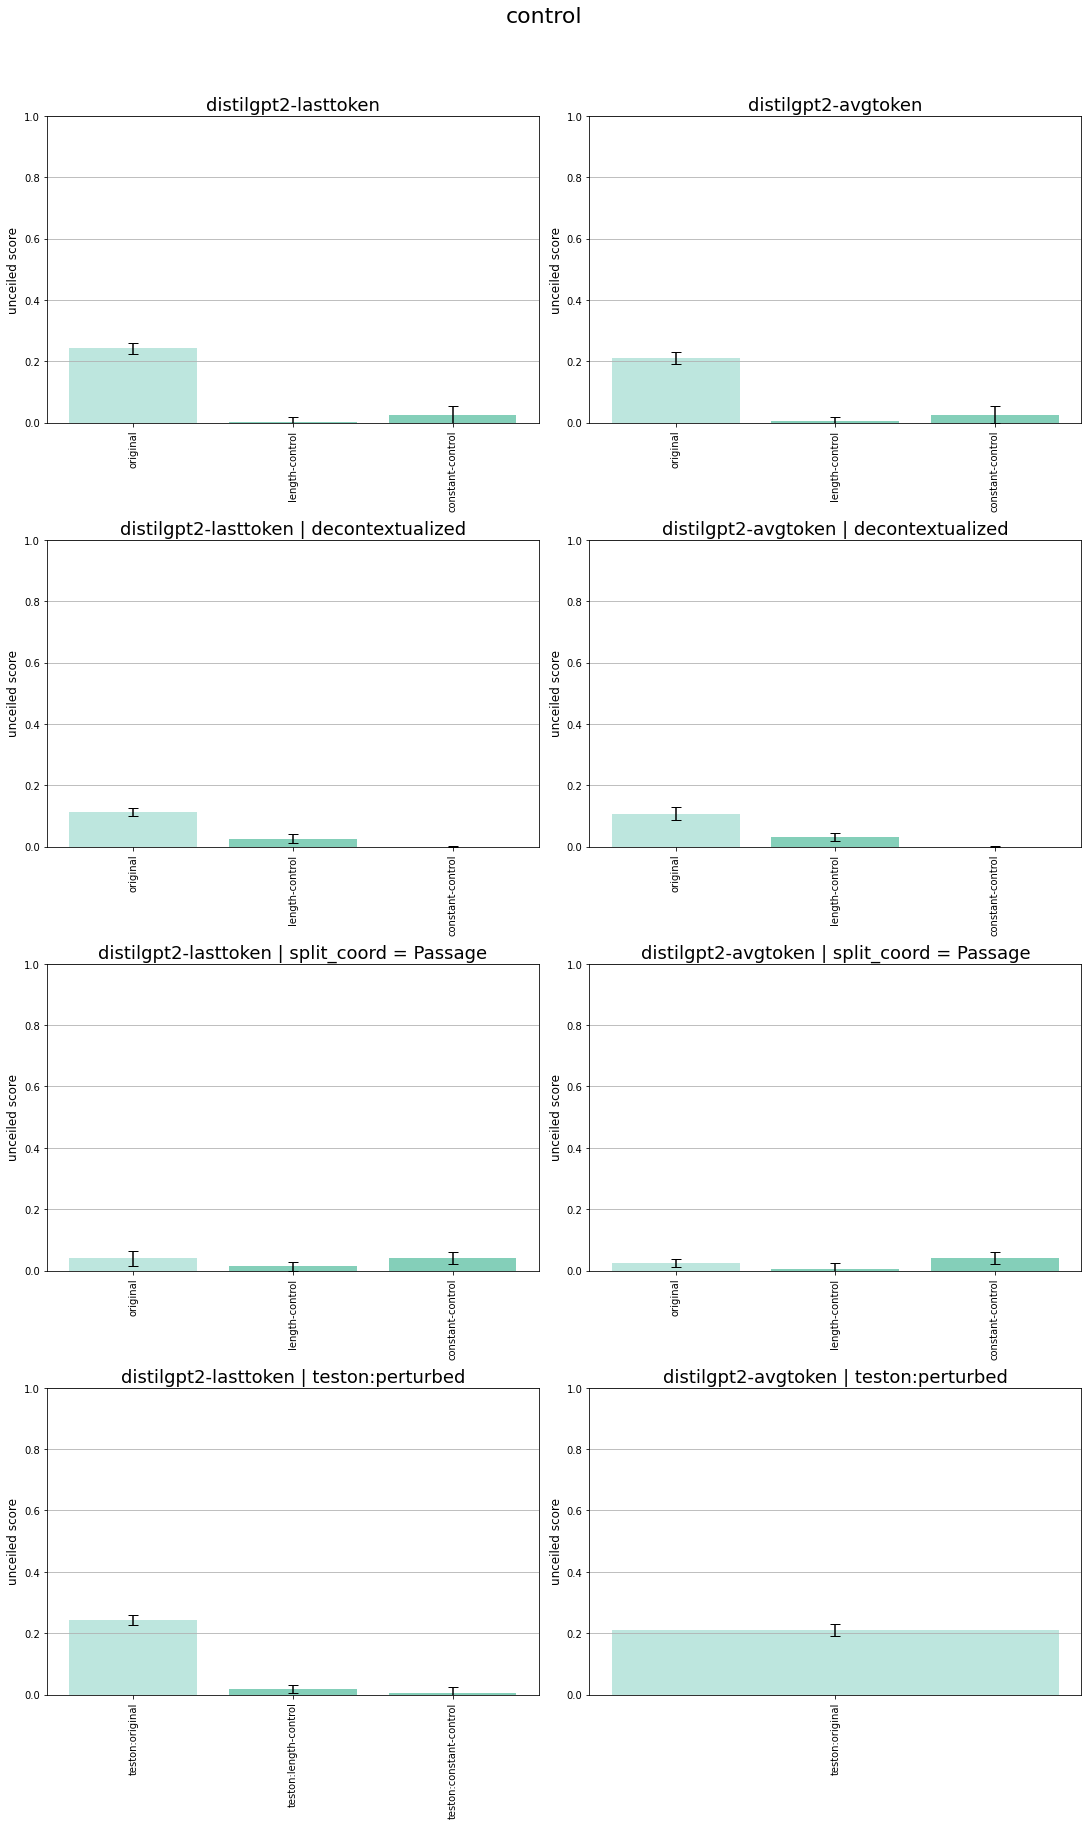

In [25]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="control")

distilgpt2
distilgpt2-avgtoken
distilgpt2 | decontextualized
distilgpt2-avgtoken | decontextualized
distilgpt2 | split_coord = Passage
distilgpt2-avgtoken | split_coord = Passage
distilgpt2 | teston:perturbed
distilgpt2-avgtoken | teston:perturbed


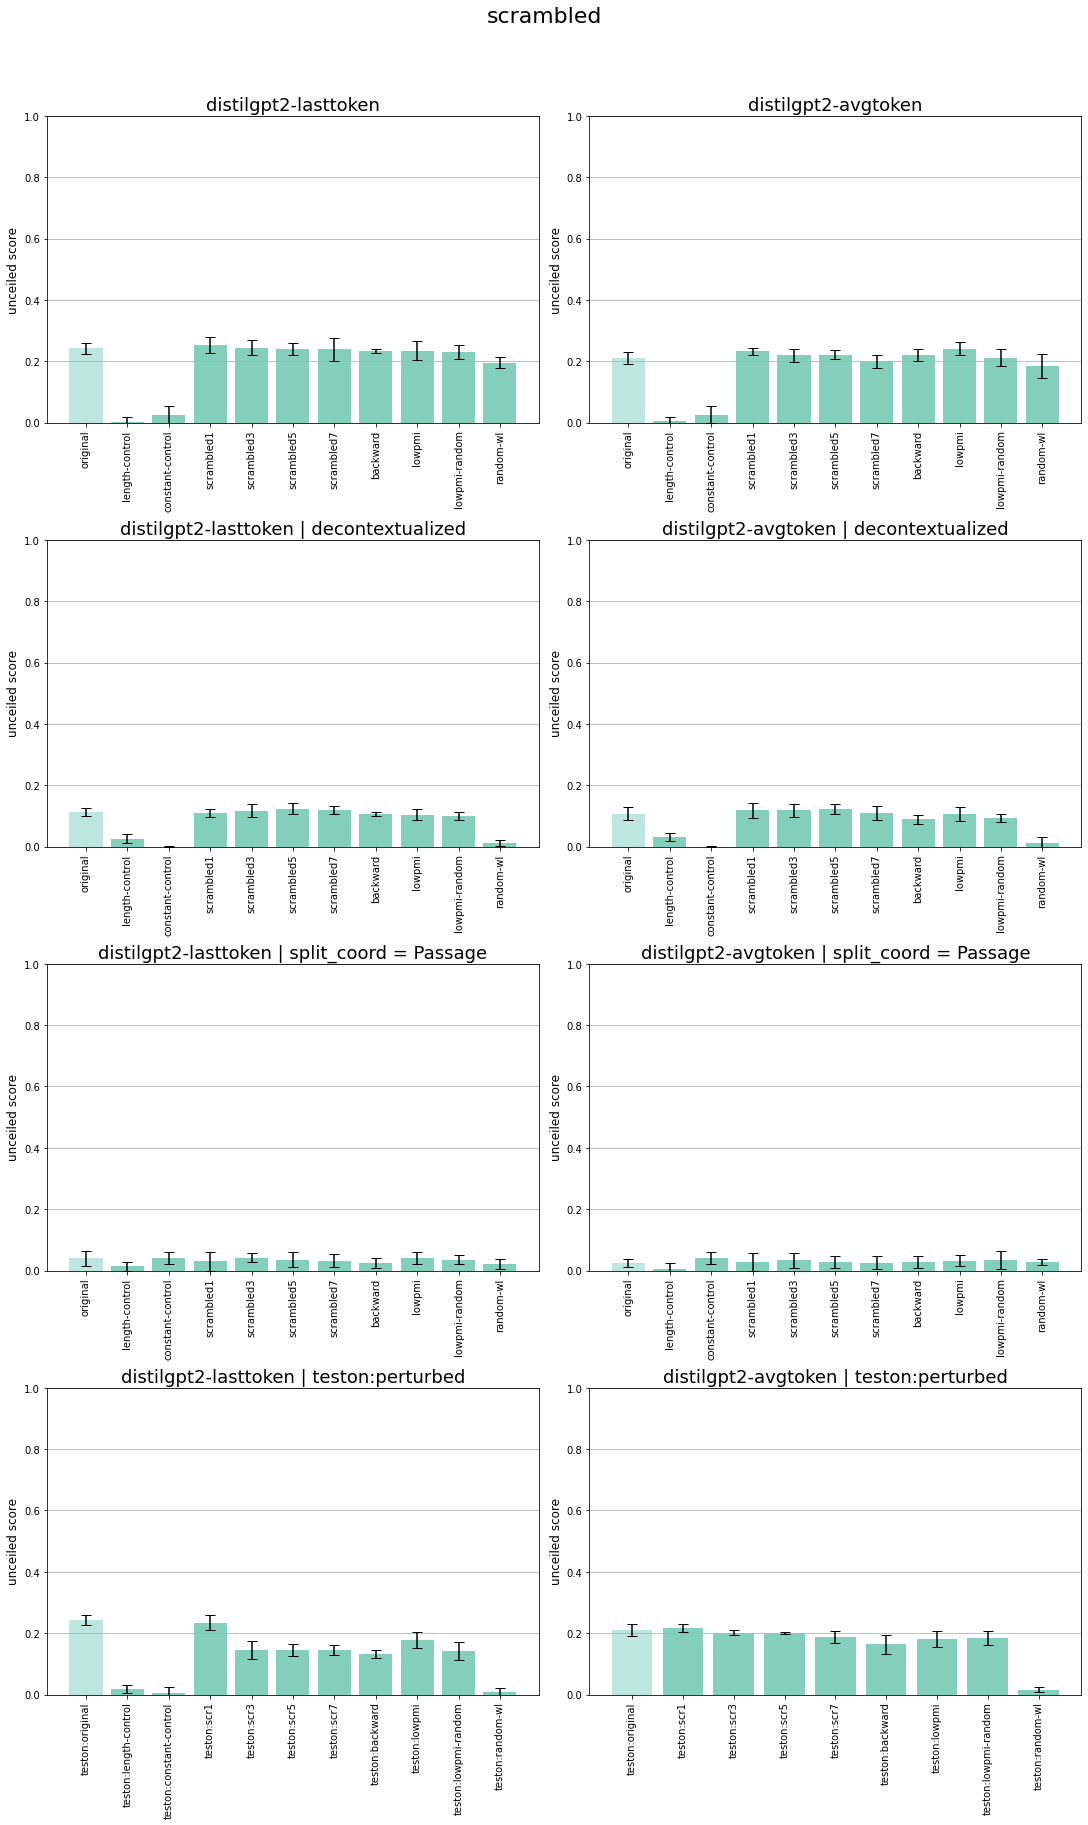

In [26]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="scrambled")

distilgpt2
distilgpt2-avgtoken
distilgpt2 | decontextualized
distilgpt2-avgtoken | decontextualized
distilgpt2 | split_coord = Passage
distilgpt2-avgtoken | split_coord = Passage
distilgpt2 | teston:perturbed
distilgpt2-avgtoken | teston:perturbed


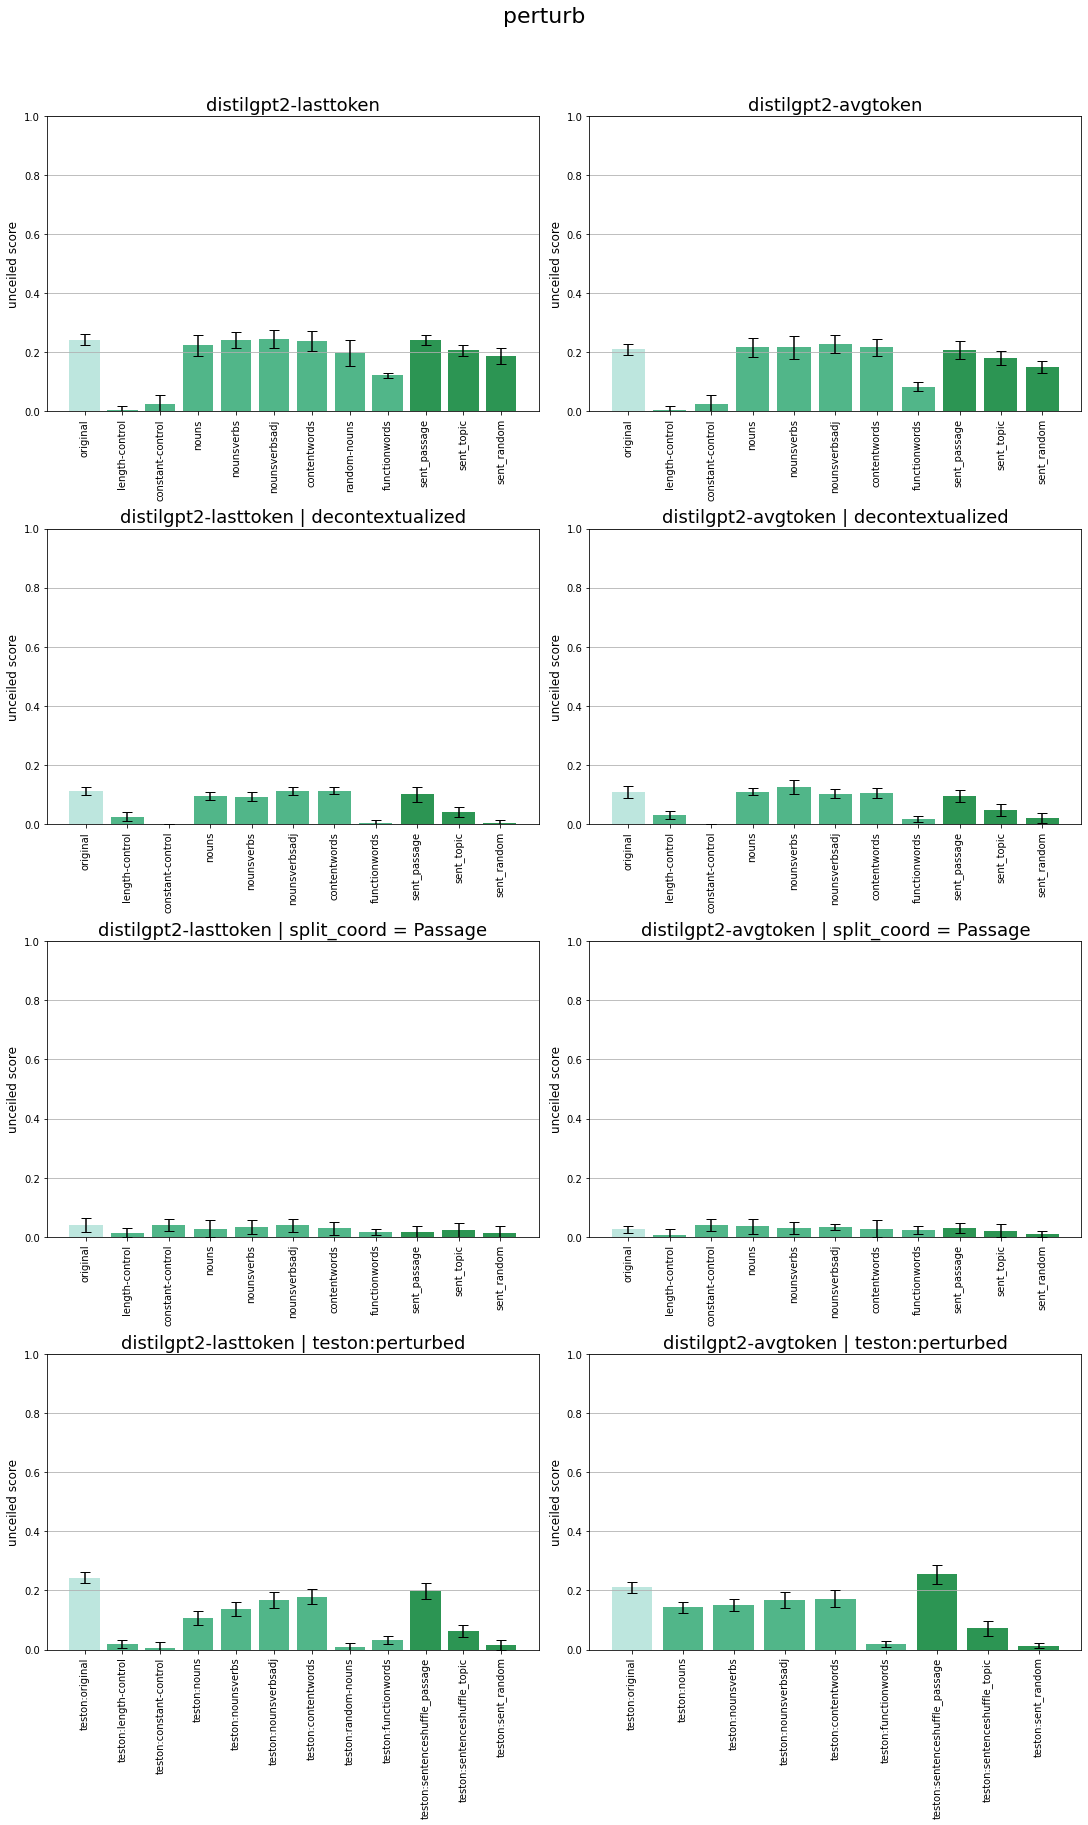

In [27]:
get_subplots_loop(['distilgpt2', 'distilgpt2-avgtoken'], scr_perturb="perturb")